**0. Importing the data and cleaning it**

In [4]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from sklearn import datasets
!pip install folium
!pip install textblob
!pip install shap
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.4/251.4 kB 2.2 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#Exporting the data
df = pd.read_excel('/content/drive/MyDrive/Homestays_Data.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      74111 non-null  int64         
 1   log_price               74111 non-null  float64       
 2   property_type           74111 non-null  object        
 3   room_type               74111 non-null  object        
 4   amenities               74111 non-null  object        
 5   accommodates            74111 non-null  int64         
 6   bathrooms               73911 non-null  float64       
 7   bed_type                74111 non-null  object        
 8   cancellation_policy     74111 non-null  object        
 9   cleaning_fee            74111 non-null  bool          
 10  city                    74111 non-null  object        
 11  description             74105 non-null  object        
 12  first_review            58247 non-null  dateti

In [7]:
# Filling the empty places with median
num_columns = ['id', 'log_price', 'accommodates', 'bathrooms', 'host_response_rate', 'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds']
for i in num_columns:
    df[i].fillna(df[i].median(), inplace=True)

In [8]:
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,96.0,https://a0.muscache.com/im/pictures/72208dad-9...,94117,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [9]:
df.dtypes

id                                 int64
log_price                        float64
property_type                     object
room_type                         object
amenities                         object
accommodates                       int64
bathrooms                        float64
bed_type                          object
cancellation_policy               object
cleaning_fee                        bool
city                              object
description                       object
first_review              datetime64[ns]
host_has_profile_pic              object
host_identity_verified            object
host_response_rate               float64
host_since                datetime64[ns]
instant_bookable                  object
last_review               datetime64[ns]
latitude                         float64
longitude                        float64
name                              object
neighbourhood                     object
number_of_reviews                  int64
review_scores_ra

In [10]:
# Removing the rows with duplicate values
df.drop_duplicates(inplace=True)
df.shape

(74111, 29)

In [11]:
# Dividing into categorical and numerical columns
categorical_columns = ['property_type', 'room_type', 'bed_type','amenities', 'cancellation_policy','cleaning_fee', 'city', 'description', 'first_review', 'host_has_profile_pic',
                       'host_identity_verified', 'host_since', 'instant_bookable', 'last_review', 'name', 'neighbourhood', 'thumbnail_url']
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)


In [12]:
# Removing rows with missing date columns, zipcode column
df = df.dropna(subset=['first_review', 'host_since', 'last_review', 'zipcode'])
df.shape

(73145, 29)

In [13]:
# Filling the empty latitude and longitude rows with reference to neighbourhood
mean_coords = df.groupby('neighbourhood')[['latitude', 'longitude']].mean()

# Applying the mean coordinates to missing values
df = df.set_index('neighbourhood')
df['latitude'].fillna(mean_coords['latitude'], inplace=True)
df['longitude'].fillna(mean_coords['longitude'], inplace=True)
df.reset_index(inplace=True)

In [14]:
# Checking the dataset after handling missing values
df.isnull().sum(), df.shape

(neighbourhood             0
 id                        0
 log_price                 0
 property_type             0
 room_type                 0
 amenities                 0
 accommodates              0
 bathrooms                 0
 bed_type                  0
 cancellation_policy       0
 cleaning_fee              0
 city                      0
 description               0
 first_review              0
 host_has_profile_pic      0
 host_identity_verified    0
 host_response_rate        0
 host_since                0
 instant_bookable          0
 last_review               0
 latitude                  0
 longitude                 0
 name                      0
 number_of_reviews         0
 review_scores_rating      0
 thumbnail_url             0
 zipcode                   0
 bedrooms                  0
 beds                      0
 dtype: int64,
 (73145, 29))

**1. Feature Engineering**

In [15]:
# Calculating host_tenure
from datetime import datetime, date

# today's date
today = datetime.today().strftime('%d-%m-%y')

# convert the string to datetime object
today_dt = datetime.strptime(today, '%d-%m-%y')

# convert host_since to datetime
df['host_since'] = pd.to_datetime(df['host_since'])

df.insert(17, column='host_tenure', value= (today_dt - df['host_since']).dt.days / 365)

df.head()

,neighbourhood,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,...,last_review,latitude,longitude,name,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,Brooklyn Heights,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,...,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,Hell's Kitchen,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,...,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,Harlem,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,...,2017-09-14,40.808110,-73.943756,The Garden Oasis,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,Lower Haight,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,...,2017-04-30,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,0,96.0,https://a0.muscache.com/im/pictures/72208dad-9...,94117,2.0,2.0
4,Columbia Heights,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,...,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,4,40.0,https://a0.muscache.com/im/pictures/70087089/b...,20009,0.0,1.0


In [16]:
# Removing empty rows in date columns
date_columns = ['first_review', 'host_since', 'last_review']
df.dropna(subset=date_columns, how='all', inplace=True)
df = df[df['zipcode'] != ' ']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73143 entries, 0 to 73144
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   neighbourhood           73143 non-null  object        
 1   id                      73143 non-null  int64         
 2   log_price               73143 non-null  float64       
 3   property_type           73143 non-null  object        
 4   room_type               73143 non-null  object        
 5   amenities               73143 non-null  object        
 6   accommodates            73143 non-null  int64         
 7   bathrooms               73143 non-null  float64       
 8   bed_type                73143 non-null  object        
 9   cancellation_policy     73143 non-null  object        
 10  cleaning_fee            73143 non-null  bool          
 11  city                    73143 non-null  object        
 12  description             73143 non-null  object     

In [17]:
# Filling all the empty rows in zipcode with reference to neighbourhood
def fill_empty_rows(row, column, other_column):
    if pd.isnull(row[column]):
        matches = process.extractOne(row[other_column], df[column].dropna())
        return matches[0]
    else:
        return row[column]

# Apply the function to fill empty rows in 'zipcode'
df['zipcode'] = df.apply(lambda row: fill_empty_rows(row, 'zipcode', 'neighbourhood'), axis=1)

df.isnull().sum()

neighbourhood             0
id                        0
log_price                 0
property_type             0
room_type                 0
amenities                 0
accommodates              0
bathrooms                 0
bed_type                  0
cancellation_policy       0
cleaning_fee              0
city                      0
description               0
first_review              0
host_has_profile_pic      0
host_identity_verified    0
host_response_rate        0
host_tenure               0
host_since                0
instant_bookable          0
last_review               0
latitude                  0
longitude                 0
name                      0
number_of_reviews         0
review_scores_rating      0
thumbnail_url             0
zipcode                   0
bedrooms                  0
beds                      0
dtype: int64

In [18]:
# Removing all the empty rows in zipcode
df.dropna(subset=['zipcode'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73143 entries, 0 to 73144
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   neighbourhood           73143 non-null  object        
 1   id                      73143 non-null  int64         
 2   log_price               73143 non-null  float64       
 3   property_type           73143 non-null  object        
 4   room_type               73143 non-null  object        
 5   amenities               73143 non-null  object        
 6   accommodates            73143 non-null  int64         
 7   bathrooms               73143 non-null  float64       
 8   bed_type                73143 non-null  object        
 9   cancellation_policy     73143 non-null  object        
 10  cleaning_fee            73143 non-null  bool          
 11  city                    73143 non-null  object        
 12  description             73143 non-null  object     

In [19]:
# Converting 'host_tenure' columnn from float to int in years
df['host_tenure'] = df['host_tenure'].astype(int)
host_tenure = df['host_tenure']
host_tenure.head()

0    12
1     7
2     7
3     9
4     9
Name: host_tenure, dtype: int64

In [20]:
# Calculating the number of amenities in each row as num_of_amenities
def count_items(lst):
    return len(lst)

df.insert(5, column='num_of_amenities', value = df['amenities'].apply(lambda x: count_items(x)))

In [21]:
df['num_of_amenities'].head()

0    152
1    218
2    311
3    210
4    174
Name: num_of_amenities, dtype: int64

In [22]:
# Calculating number of days since last review
df['last_review'] = pd.to_datetime(df['last_review'])

df.insert(21, column='days_since_last_review', value= (today_dt - df['last_review']).dt.days)

df.head()

,neighbourhood,id,log_price,property_type,room_type,num_of_amenities,amenities,accommodates,bathrooms,bed_type,...,last_review,latitude,longitude,name,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,Brooklyn Heights,6901257,5.010635,Apartment,Entire home/apt,152,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,...,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,Hell's Kitchen,6304928,5.129899,Apartment,Entire home/apt,218,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,...,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,Harlem,7919400,4.976734,Apartment,Entire home/apt,311,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,...,2017-09-14,40.808110,-73.943756,The Garden Oasis,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,Lower Haight,13418779,6.620073,House,Entire home/apt,210,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,...,2017-04-30,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,0,96.0,https://a0.muscache.com/im/pictures/72208dad-9...,94117,2.0,2.0
4,Columbia Heights,3808709,4.744932,Apartment,Entire home/apt,174,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,...,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,4,40.0,https://a0.muscache.com/im/pictures/70087089/b...,20009,0.0,1.0


In [23]:
# Converting the column days_since_last_review into int for number of days
df['days_since_last_review'] = df['days_since_last_review'].astype(int)
days_since_last_review = df['days_since_last_review']
days_since_last_review.head()

0    2896
1    2464
2    2473
3    2610
4    2708
Name: days_since_last_review, dtype: int64

**2. Exploratory Data Analysis (EDA)**

In [24]:
df.describe()

,id,log_price,num_of_amenities,accommodates,bathrooms,first_review,host_response_rate,host_tenure,host_since,days_since_last_review,last_review,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,7.314300e+04,73143.000000,73143.000000,73143.000000,73143.000000,73143,73143.000000,73143.000000,73143,73143.000000,73143,73143.000000,73143.000000,73143.0000,73143.000000,73143.000000,73143.000000
mean,1.126636e+07,4.781576,268.047687,3.154588,1.234424,2016-03-27 12:37:39.136212480,0.957685,9.430499,2014-07-19 16:38:50.601698048,2646.430239,2017-03-24 13:40:27.316352768,38.446581,-92.399456,21.0264,94.498407,1.265097,1.709241
min,3.440000e+02,0.000000,2.000000,1.000000,0.000000,2008-11-17 00:00:00,0.000000,6.000000,2008-03-03 00:00:00,2452.000000,2009-01-21 00:00:00,33.338905,-122.511500,0.0000,20.000000,0.000000,0.000000
25%,6.261376e+06,4.317488,195.000000,2.000000,1.000000,2015-09-17 00:00:00,1.000000,8.000000,2013-04-19 00:00:00,2498.000000,2017-03-24 00:00:00,34.127355,-118.342221,1.0000,93.000000,1.000000,1.000000
50%,1.225487e+07,4.709530,263.000000,2.000000,1.000000,2016-09-14 00:00:00,1.000000,9.000000,2014-09-29 00:00:00,2610.000000,2017-04-30 00:00:00,40.662178,-76.996983,6.0000,96.000000,1.000000,1.000000
75%,1.640490e+07,5.220356,329.000000,4.000000,1.000000,2017-01-01 00:00:00,1.000000,11.000000,2015-12-18 00:00:00,2647.000000,2017-08-20 00:00:00,40.746240,-73.954588,24.0000,99.000000,1.000000,2.000000
max,2.123090e+07,7.600402,1498.000000,16.000000,8.000000,2017-10-05 00:00:00,1.000000,16.000000,2017-10-04 00:00:00,5631.000000,2017-10-05 00:00:00,42.390437,-70.985047,605.0000,100.000000,10.000000,18.000000
std,6.082946e+06,0.716473,111.345031,2.153044,0.581456,NaN,0.143339,1.831311,NaN,206.676860,NaN,3.080760,21.705893,37.9647,6.928554,0.850777,1.252202


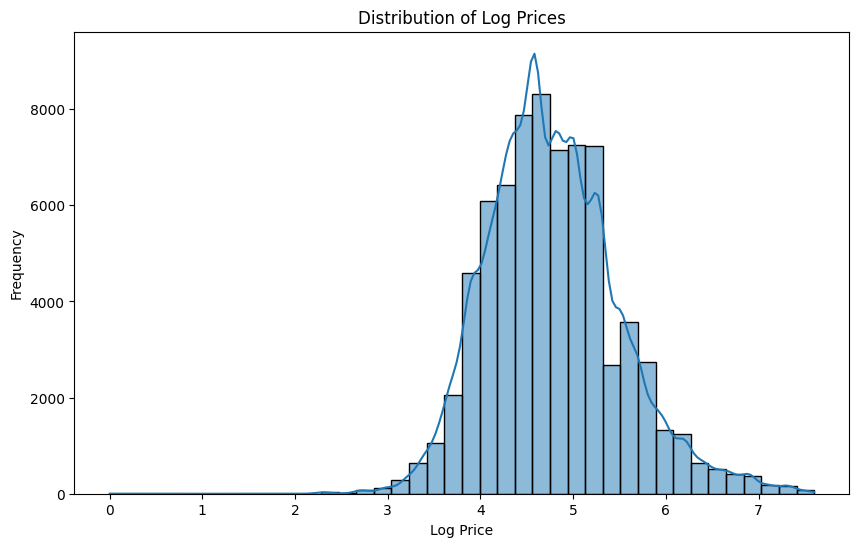

In [25]:
# Histogram of log_prices
plt.figure(figsize=(10, 6))
sns.histplot(df['log_price'], kde=True, bins=40)
plt.title('Distribution of Log Prices')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.show()

In [26]:
# Correlation matrix using only the numerical columns
subset_df = df[num_columns]

correlation_matrix = subset_df.corr()

print("Correlation Matrix for selected columns:")
print(correlation_matrix)

Correlation Matrix for selected columns:
                            id  log_price  accommodates  bathrooms  \
id                    1.000000  -0.006850     -0.005335  -0.003977   
log_price            -0.006850   1.000000      0.567190   0.354358   
accommodates         -0.005335   0.567190      1.000000   0.505265   
bathrooms            -0.003977   0.354358      0.505265   1.000000   
host_response_rate   -0.003278   0.001665      0.020343  -0.002445   
latitude             -0.003100  -0.001974     -0.078477  -0.136827   
longitude            -0.001224  -0.047310     -0.085408  -0.133950   
number_of_reviews     0.002799  -0.032401      0.041953  -0.041096   
review_scores_rating  0.001250   0.084544     -0.021726   0.012078   
bedrooms             -0.007557   0.472941      0.708945   0.589455   
beds                 -0.008718   0.441394      0.809930   0.525634   

                      host_response_rate  latitude  longitude  \
id                             -0.003278 -0.003100  -

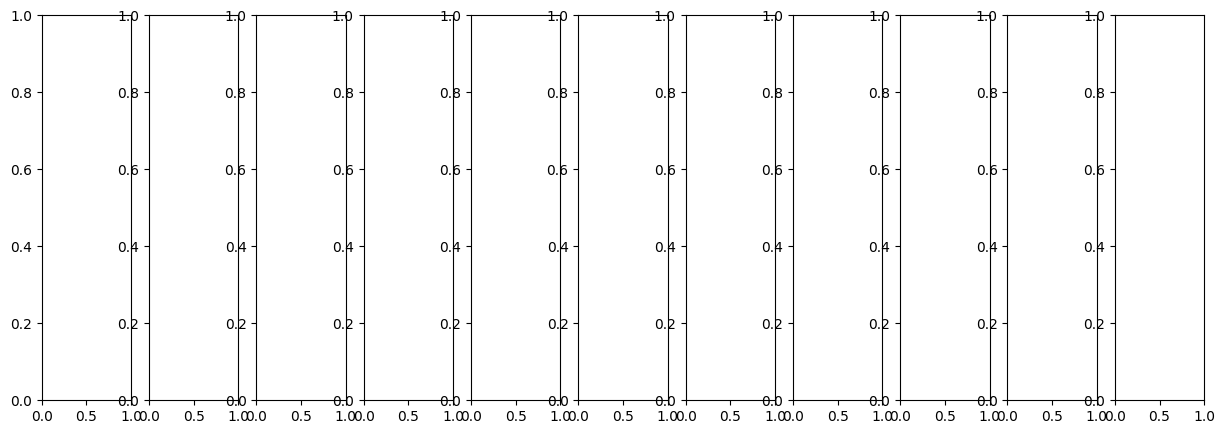

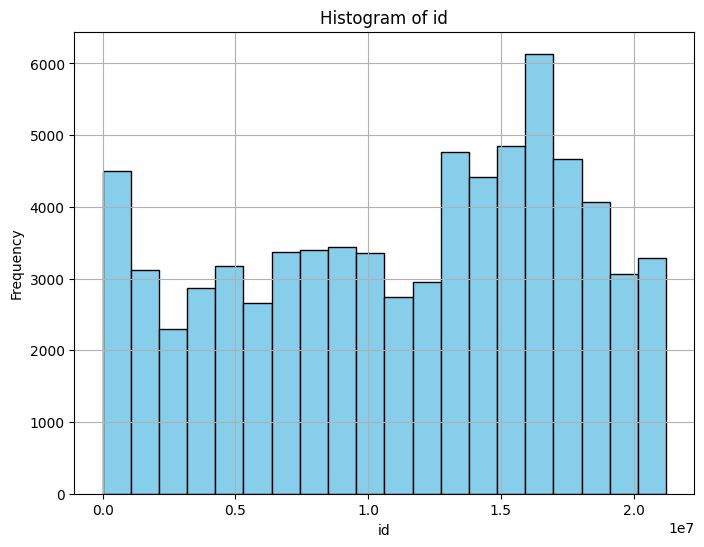

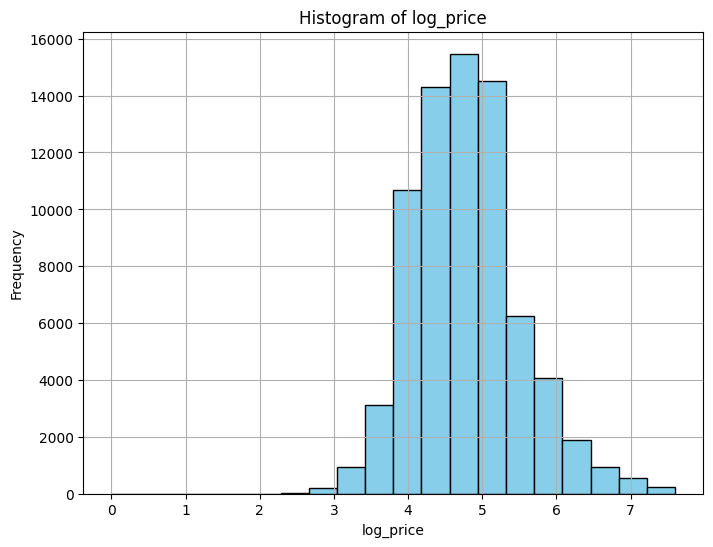

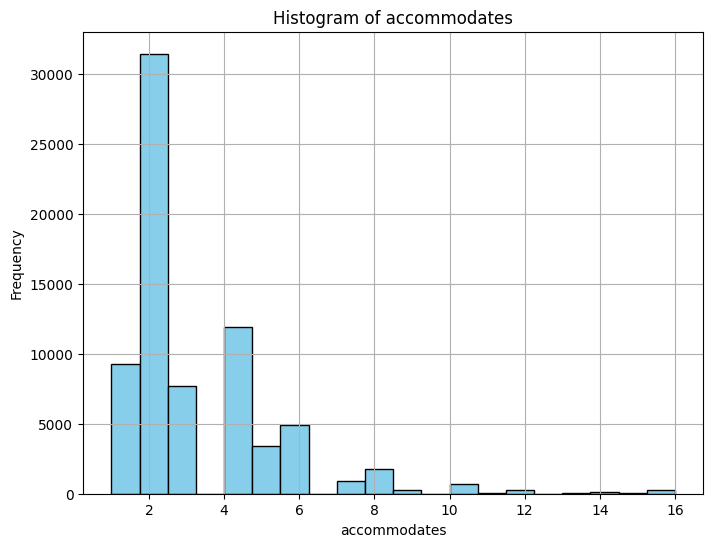

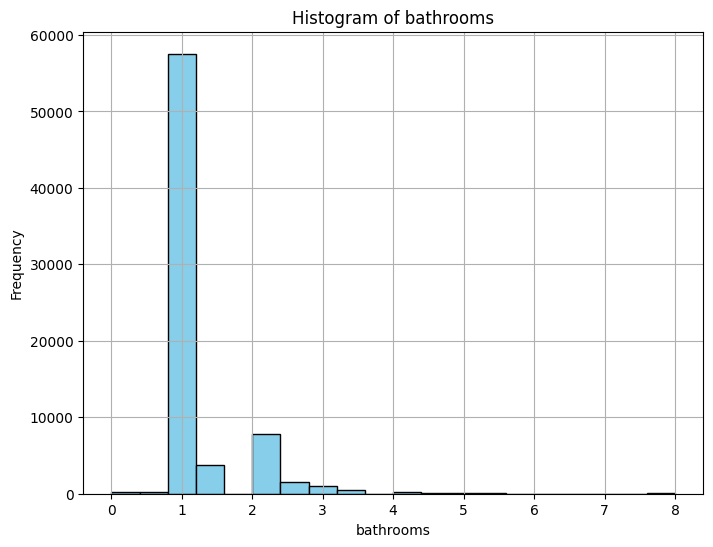

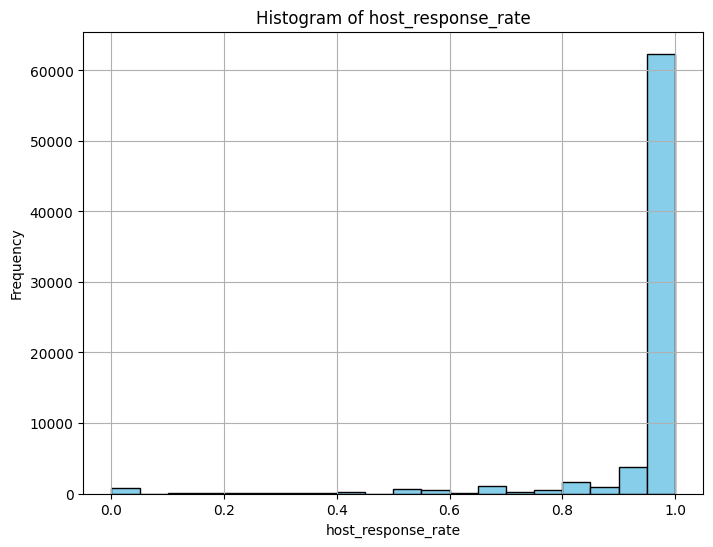

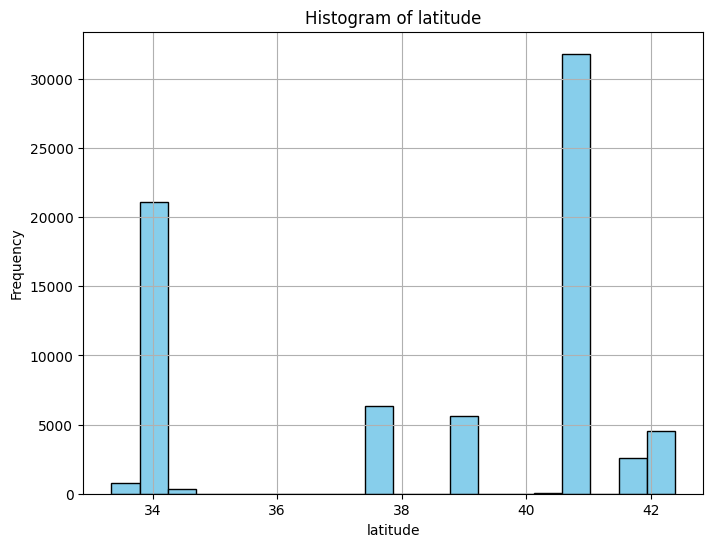

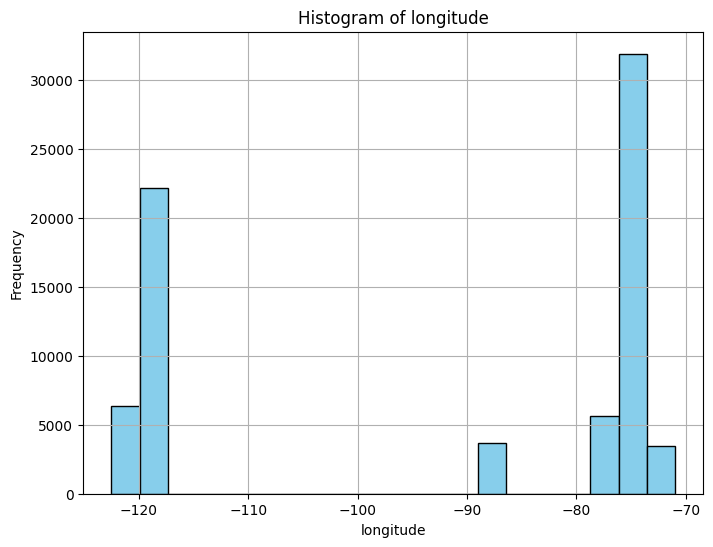

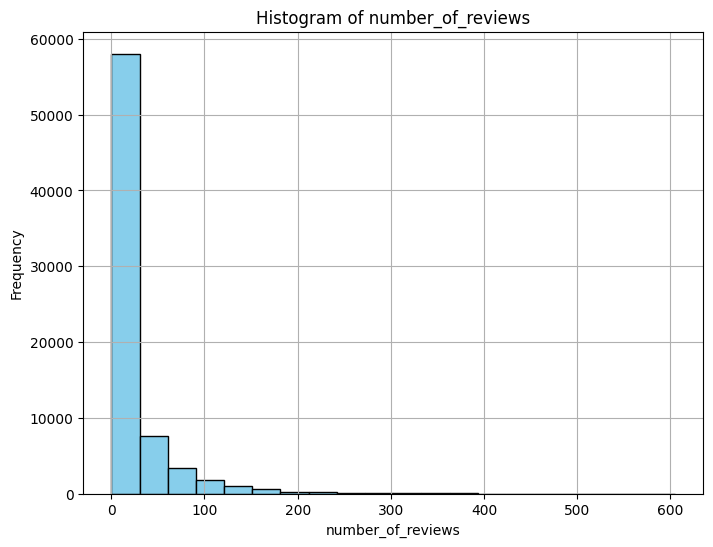

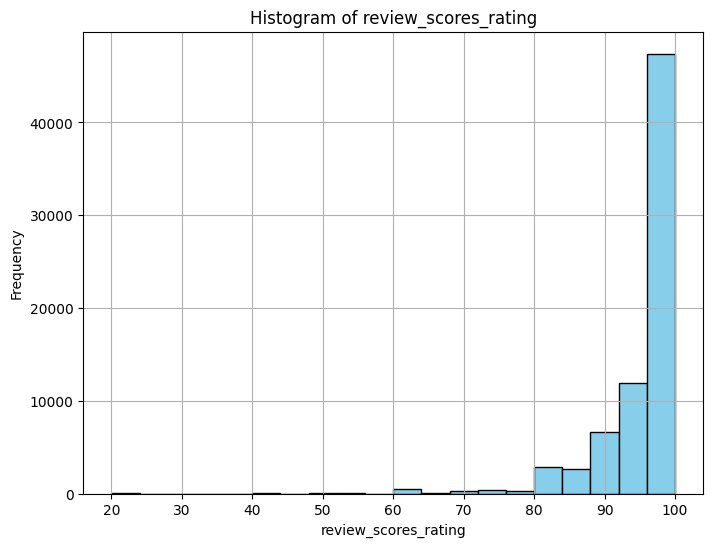

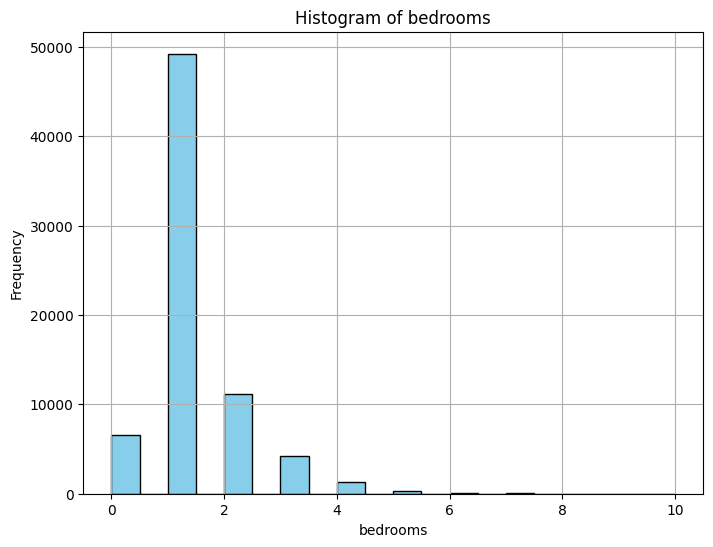

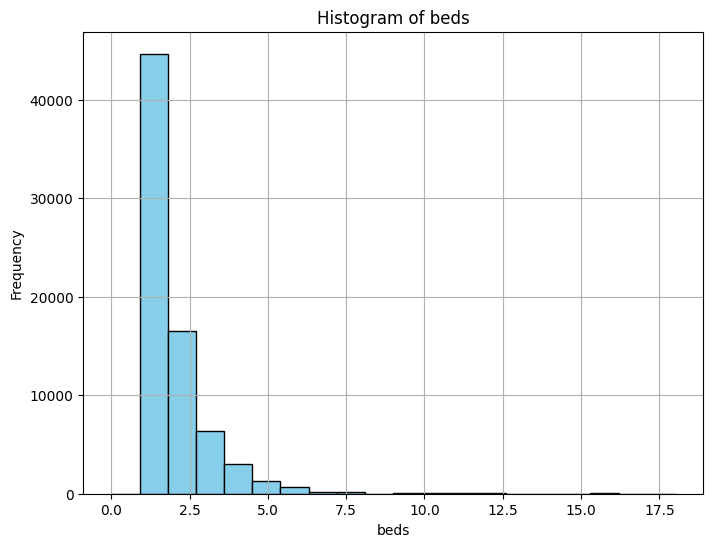

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=len(num_columns), figsize=(15, 5))

# Plot histograms for numerical columns
for column in num_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

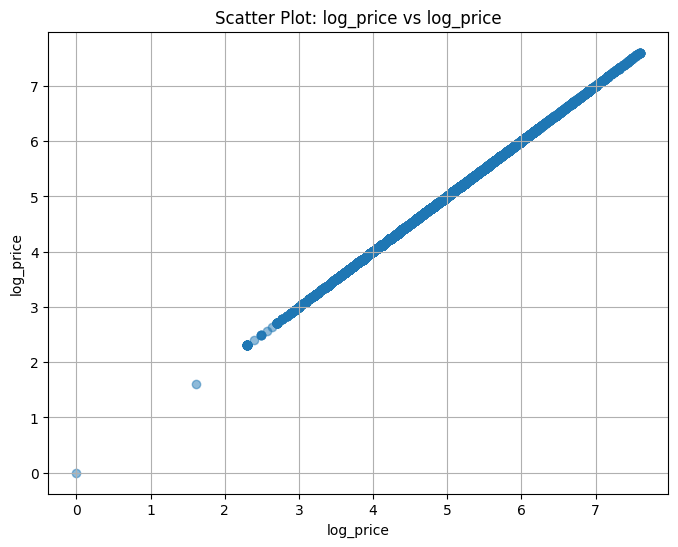

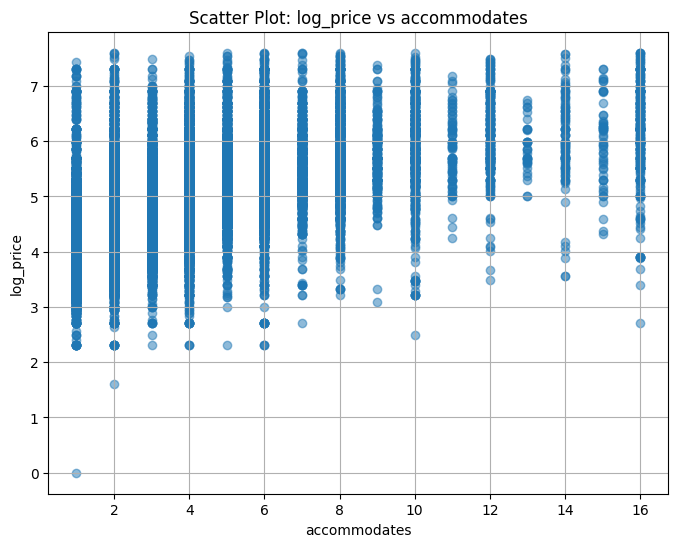

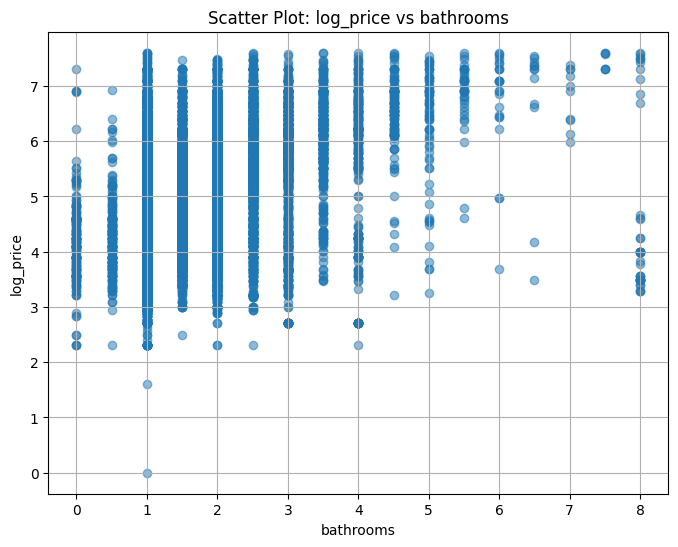

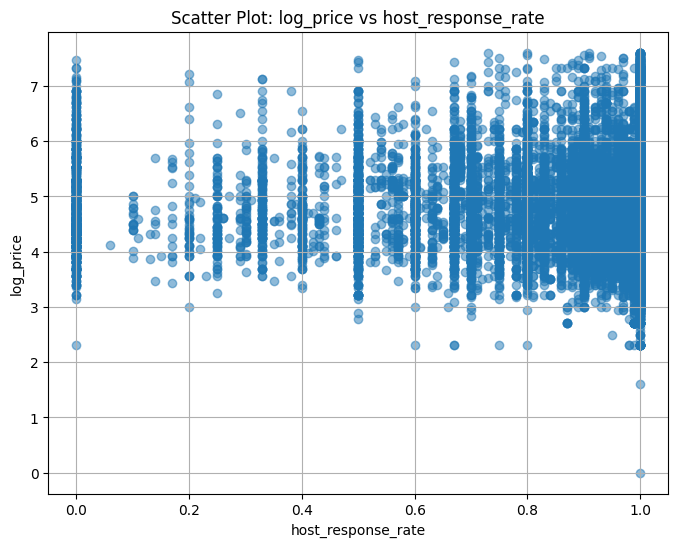

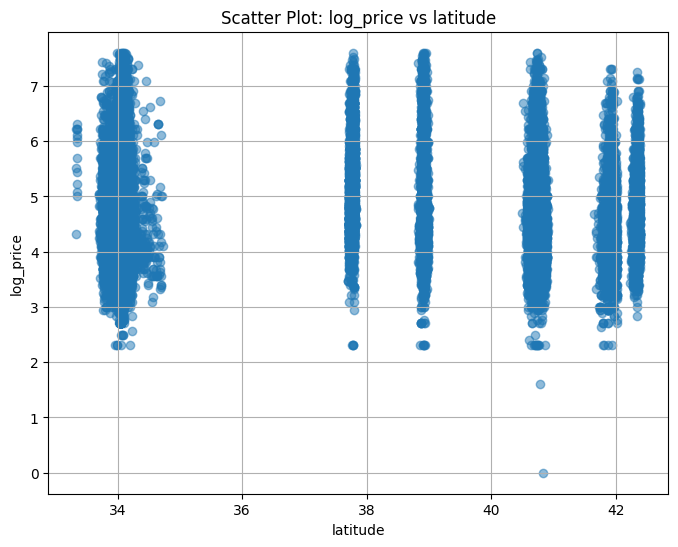

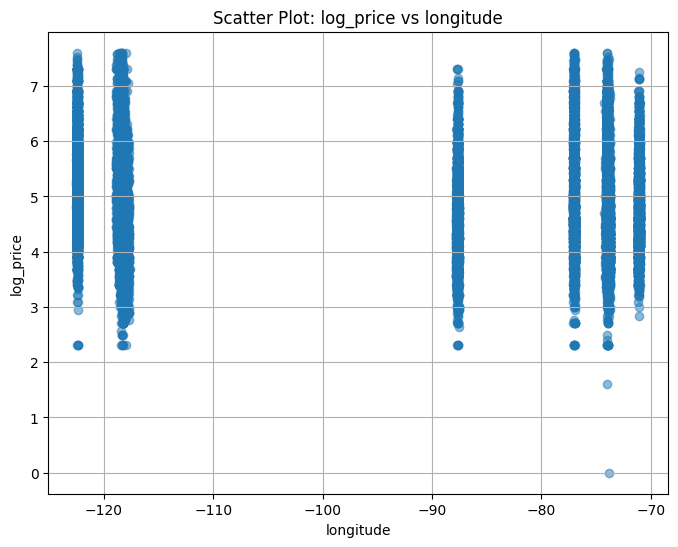

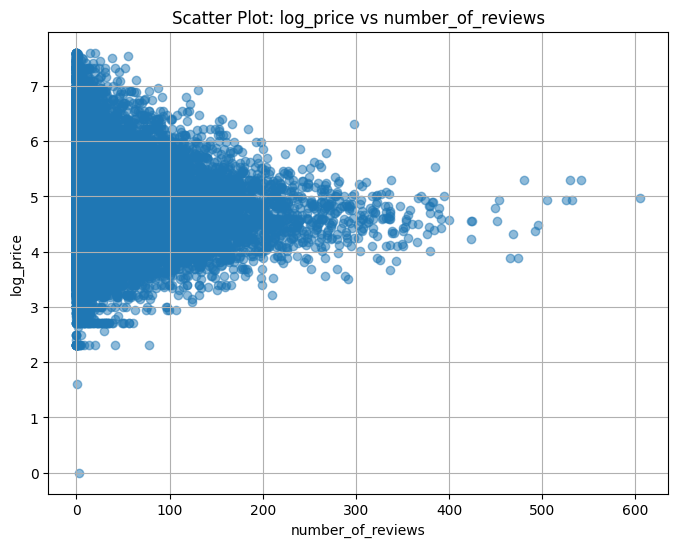

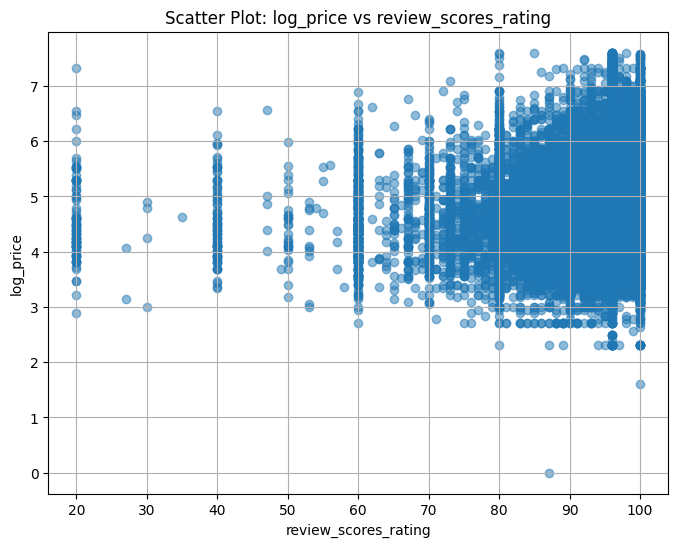

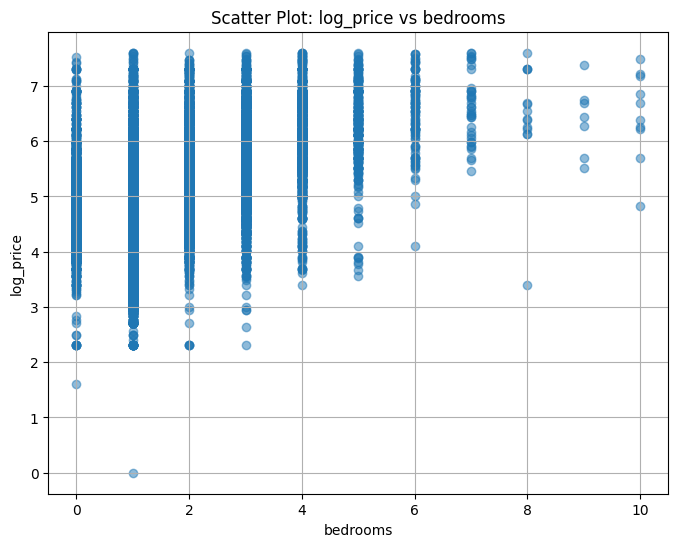

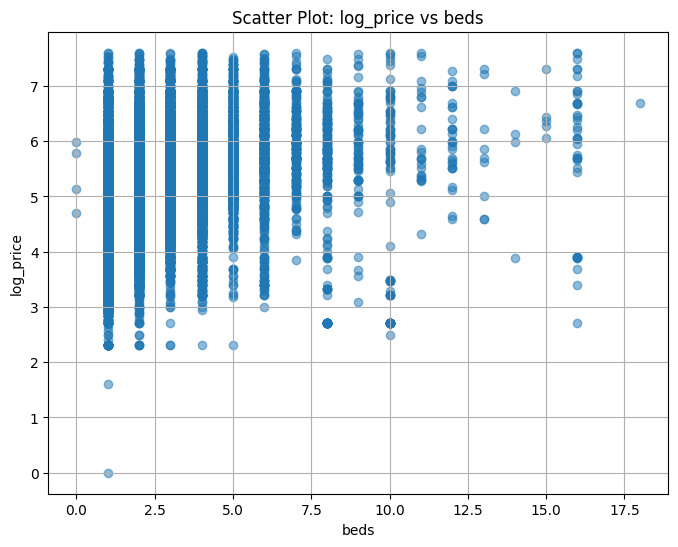

In [28]:
# Scatterplot for numerical columns wrt log_price
x_columns = subset_df.drop("log_price", axis = 1)
x_columns = subset_df.drop("id", axis = 1)

for i, column1 in enumerate(x_columns):
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    plt.scatter(df[column1], df['log_price'], alpha=0.5)  # Create scatter plot
    plt.title(f'Scatter Plot: log_price vs {column1}')  # Set title
    plt.xlabel(column1)  # Set x-axis label
    plt.ylabel('log_price')  # Set y-axis label
    plt.grid(True)  # Add grid
    plt.show()

**3. Sentiment Analysis on Textual Data**

In [29]:
from textblob import TextBlob

# Function to calculate sentiment score using TextBlob
def calculate_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis to the 'description' column
df['sentiment_score'] = df['description'].apply(calculate_sentiment)

In [30]:
df['sentiment_score']

0        0.716667
1        0.250000
2        0.274085
3        0.281515
4        0.196795
           ...   
73140    0.600000
73141    0.174256
73142    0.229167
73143    0.320370
73144    0.140986
Name: sentiment_score, Length: 73143, dtype: float64

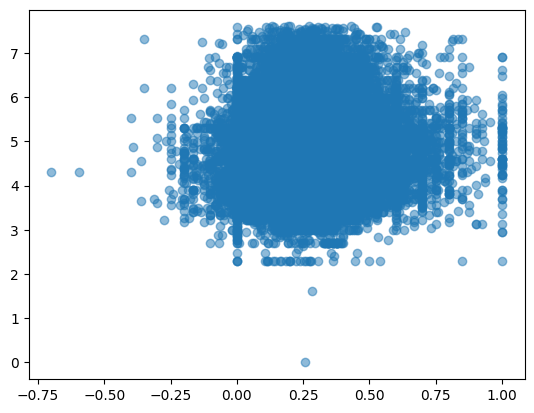

In [31]:
plt.scatter(df['sentiment_score'], df['log_price'], alpha=0.5)  # Create scatter plot

**4. Categorical Data Encoding**

In [32]:
# Encoding categorical data
encoding_columns = ['room_type', 'city', 'property_type']

In [33]:
from sklearn.preprocessing import OneHotEncoder

# Applying one-hot encoding
onehot_encoder = OneHotEncoder(sparse_output=False)
encoded_data = pd.DataFrame(onehot_encoder.fit_transform(df[encoding_columns]))
encoded_data.columns = onehot_encoder.get_feature_names_out(encoding_columns)

In [34]:
# Dropping original categorical columns and adding encoded columns, df_new variable created for feature engineering the cleaned data
df_new = df.drop(columns=encoding_columns)
df_new = pd.concat([df_new, encoded_data], axis=1)

In [35]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73145 entries, 0 to 5232
Data columns (total 74 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   neighbourhood                     73143 non-null  object        
 1   id                                73143 non-null  float64       
 2   log_price                         73143 non-null  float64       
 3   num_of_amenities                  73143 non-null  float64       
 4   amenities                         73143 non-null  object        
 5   accommodates                      73143 non-null  float64       
 6   bathrooms                         73143 non-null  float64       
 7   bed_type                          73143 non-null  object        
 8   cancellation_policy               73143 non-null  object        
 9   cleaning_fee                      73143 non-null  object        
 10  description                       73143 non-null  ob

In [36]:
# Dropping all non numeric categorical columns
non_num_columns = ['id', 'neighbourhood', 'amenities', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'description', 'first_review', 'host_has_profile_pic', 'host_identity_verified',
                   'host_since', 'instant_bookable', 'zipcode', 'last_review', 'name', 'thumbnail_url']
df_new = df_new.drop(columns = non_num_columns, axis = 1)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73145 entries, 0 to 5232
Data columns (total 58 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   log_price                         73143 non-null  float64
 1   num_of_amenities                  73143 non-null  float64
 2   accommodates                      73143 non-null  float64
 3   bathrooms                         73143 non-null  float64
 4   host_response_rate                73143 non-null  float64
 5   host_tenure                       73143 non-null  float64
 6   days_since_last_review            73143 non-null  float64
 7   latitude                          73143 non-null  float64
 8   longitude                         73143 non-null  float64
 9   number_of_reviews                 73143 non-null  float64
 10  review_scores_rating              73143 non-null  float64
 11  bedrooms                          73143 non-null  float64
 12  beds      

In [37]:
df_new = df_new.dropna()

In [38]:
# Checking the dataset after feature engineering
df_new.head(), df_new.shape

(   log_price  num_of_amenities  accommodates  bathrooms  host_response_rate  \
 0   5.010635             152.0           3.0        1.0                 1.0   
 1   5.129899             218.0           7.0        1.0                 1.0   
 2   4.976734             311.0           5.0        1.0                 1.0   
 3   6.620073             210.0           4.0        1.0                 1.0   
 4   4.744932             174.0           2.0        1.0                 1.0   
 
    host_tenure  days_since_last_review   latitude   longitude  \
 0         12.0                  2896.0  40.696524  -73.991617   
 1          7.0                  2464.0  40.766115  -73.989040   
 2          7.0                  2473.0  40.808110  -73.943756   
 3          9.0                  2610.0  37.772004 -122.431619   
 4          9.0                  2708.0  38.925627  -77.034596   
 
    number_of_reviews  ...  property_type_Serviced apartment  \
 0                2.0  ...                              

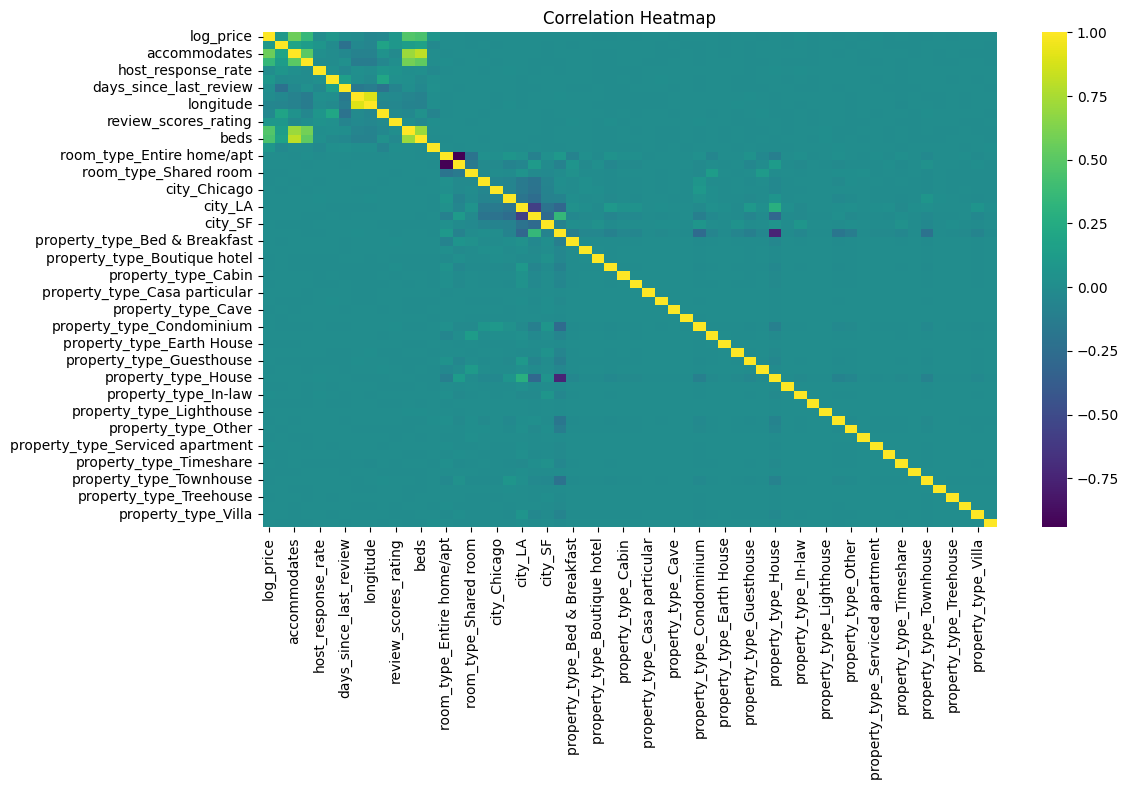

In [39]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_new.corr(), annot=False, fmt=".2f", cmap='viridis')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

**5. Model development and Training**

In [40]:
# Using test_train_split
from sklearn.model_selection import train_test_split

In [41]:
# Defining the target variable and features
X = df_new.drop('log_price', axis=1)
y = df_new['log_price']

In [42]:
# Splitting the data into training and testing sets with test size as 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [43]:
# Checking the shape of the split datasets
split_shapes = {
    "Training Features": X_train.shape,
    "Training Labels": y_train.shape,
    "Testing Features": X_test.shape,
    "Testing Labels": y_test.shape
}

split_shapes

{'Training Features': (51198, 57),
 'Training Labels': (51198,),
 'Testing Features': (21943, 57),
 'Testing Labels': (21943,)}

In [44]:
# Check for missing values in X_train
missing_values = X_train.isnull().sum()

print(missing_values)

num_of_amenities                    0
accommodates                        0
bathrooms                           0
host_response_rate                  0
host_tenure                         0
days_since_last_review              0
latitude                            0
longitude                           0
number_of_reviews                   0
review_scores_rating                0
bedrooms                            0
beds                                0
sentiment_score                     0
room_type_Entire home/apt           0
room_type_Private room              0
room_type_Shared room               0
city_Boston                         0
city_Chicago                        0
city_DC                             0
city_LA                             0
city_NYC                            0
city_SF                             0
property_type_Apartment             0
property_type_Bed & Breakfast       0
property_type_Boat                  0
property_type_Boutique hotel        0
property_typ

In [45]:
# Applying linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

In [46]:
# Predicting on the test set
y_pred_linear_reg = linear_reg.predict(X_test)

In [47]:
# Evaluating the model
mse_linear_reg = mean_squared_error(y_test, y_pred_linear_reg)
r2_linear_reg = r2_score(y_test, y_pred_linear_reg)

mse_linear_reg, r2_linear_reg

(0.32060571949075345, 0.37013952280110196)

In [48]:
# Using Random forest as model
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse_rf = mean_squared_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)

mse_rf, r2_rf

(0.1820414222955667, 0.642362284430928)

In [49]:
# Using gradient boost as model
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=1000, random_state = 42)

# Fit the model to the training data
gb_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_gb = gb_model.predict(X_test)

# Evaluate the model
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

mse_gb, r2_gb

(0.17828249871157525, 0.6497470478909428)

**6. Predictive Performance Assesment**

In [50]:
# Import the shap module
import shap

100%|===================| 51162/51198 [07:11<00:00]       

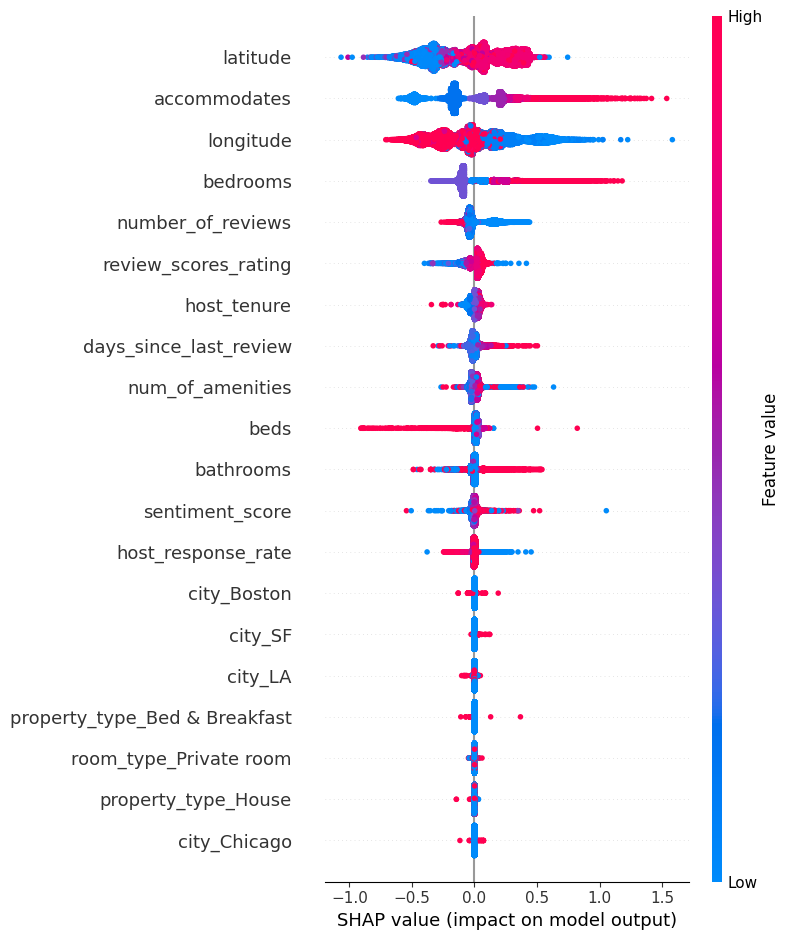

In [51]:
# Initialize shap explainer with the trained model
explainer = shap.Explainer(gb_model, X_train)

# Calculate SHAP values for all features in the training data
shap_values = explainer.shap_values(X_train, check_additivity=False)

# Visualize SHAP summary plot to see feature importance
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

# If you want to focus on specific features, you can use force plot
# For example, let's focus on the first instance in the dataset
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

# Display the plots
plt.show()

Root Mean Squared Error (RMSE): 0.42223512254616535
R-squared: 0.6497470478909428


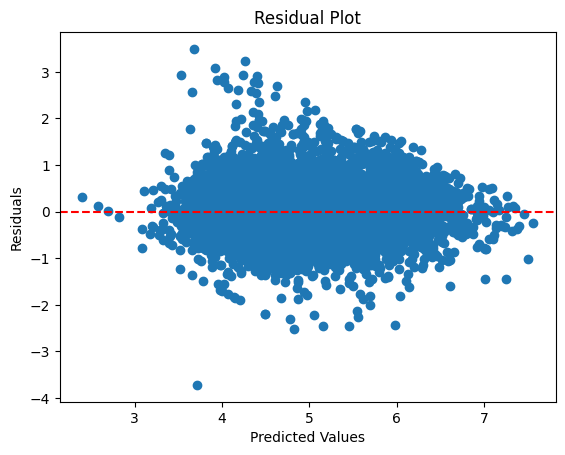

In [52]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred_gb)
print("R-squared:", r_squared)

# Plot residuals to check for any patterns
residuals = y_test - y_pred_gb
plt.scatter(y_pred_gb, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

 The final model was choosen as Gradient boost with 1000 n_estimators and random_state of 42. It gave us a MSE of 0.1782, R2 score of 0.6494 and RMSE of 0.422 which were the best in the given set of models. According to the shap values, the parameters on which log_price is mostly dependent on are 'accomodates', 'latitude', 'longitude', 'bedrooms', 'bathrooms', and 'beds.'